In [0]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [0]:
from fastai.vision import *
from fastai.callbacks.hooks import *
from fastai.utils.mem import *

In [5]:
path = untar_data(URLs.CAMVID)
path.ls()

[PosixPath('/root/.fastai/data/camvid/codes.txt'),
 PosixPath('/root/.fastai/data/camvid/images'),
 PosixPath('/root/.fastai/data/camvid/valid.txt'),
 PosixPath('/root/.fastai/data/camvid/labels')]

In [0]:
path_lbl = path/'labels'
path_img = path/'images'

# Data

In [7]:
fnames = get_image_files(path_img)
fnames[:3]

[PosixPath('/root/.fastai/data/camvid/images/0001TP_008730.png'),
 PosixPath('/root/.fastai/data/camvid/images/0006R0_f01380.png'),
 PosixPath('/root/.fastai/data/camvid/images/0016E5_02400.png')]

In [8]:
lbl_names = get_image_files(path_lbl)
lbl_names[:3]

[PosixPath('/root/.fastai/data/camvid/labels/0006R0_f03030_P.png'),
 PosixPath('/root/.fastai/data/camvid/labels/0016E5_08149_P.png'),
 PosixPath('/root/.fastai/data/camvid/labels/Seq05VD_f04440_P.png')]

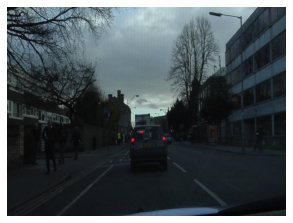

In [9]:
img_f = fnames[0]
img = open_image(img_f)
img.show(figsize=(5,5))

In [0]:
get_y_fn = lambda x:path_lbl/f'{x.stem}_P{x.suffix}'

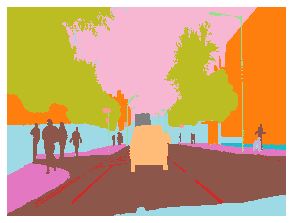

In [11]:
mask = open_mask(get_y_fn(img_f))
mask.show(figsize=(5,5),alpha=1)
#Not a usual image file. We are returning only integers. So use open_mask

In [0]:
open_mask?

In [13]:
mask.shape

torch.Size([1, 720, 960])

In [0]:
src_size = np.array(mask.shape[1:])

In [15]:
src_size

array([720, 960])

In [16]:
mask.data

tensor([[[26, 26, 26,  ...,  4,  4,  4],
         [26, 26, 26,  ...,  4,  4,  4],
         [26, 26, 26,  ...,  4,  4,  4],
         ...,
         [17, 17, 17,  ..., 30, 30, 30],
         [17, 17, 17,  ..., 30, 30, 30],
         [17, 17, 17,  ..., 30, 30, 30]]])

In [17]:
codes = np.loadtxt(path/'codes.txt',dtype= str);codes

array(['Animal', 'Archway', 'Bicyclist', 'Bridge', 'Building', 'Car', 'CartLuggagePram', 'Child', 'Column_Pole',
       'Fence', 'LaneMkgsDriv', 'LaneMkgsNonDriv', 'Misc_Text', 'MotorcycleScooter', 'OtherMoving', 'ParkingBlock',
       'Pedestrian', 'Road', 'RoadShoulder', 'Sidewalk', 'SignSymbol', 'Sky', 'SUVPickupTruck', 'TrafficCone',
       'TrafficLight', 'Train', 'Tree', 'Truck_Bus', 'Tunnel', 'VegetationMisc', 'Void', 'Wall'], dtype='<U17')

In [18]:
len(codes)

32

# Datasets

In [0]:
# free = gpu_mem_get_free_no_cache()
# free

In [0]:
size = src_size//2
bs = 2

In [0]:
data = (SegmentationItemList.from_folder(path_img)
        #Where to find the data? -> in path_img and its subfolders
        .split_by_fname_file('../valid.txt')
        #How to split in train/valid? -> randomly with the default 20% in valid
        .label_from_func(get_y_fn, classes=codes)
        #How to label? -> use the label function on the file name of the data
        .transform(get_transforms(), tfm_y=True, size=size)
        #Data augmentation? -> use tfms with a size of 128, also transform the label images
        .databunch(bs=bs))
 

In [22]:
doc(SegmentationItemList) # For mask segmentation

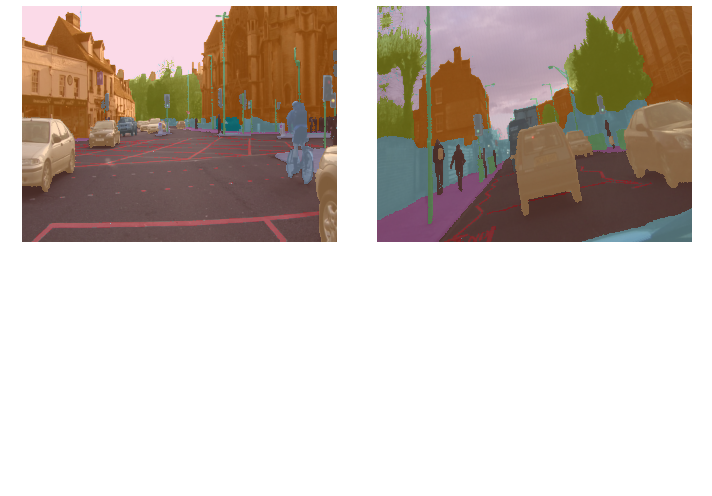

In [23]:
data.show_batch(2,figsize=(10,7))

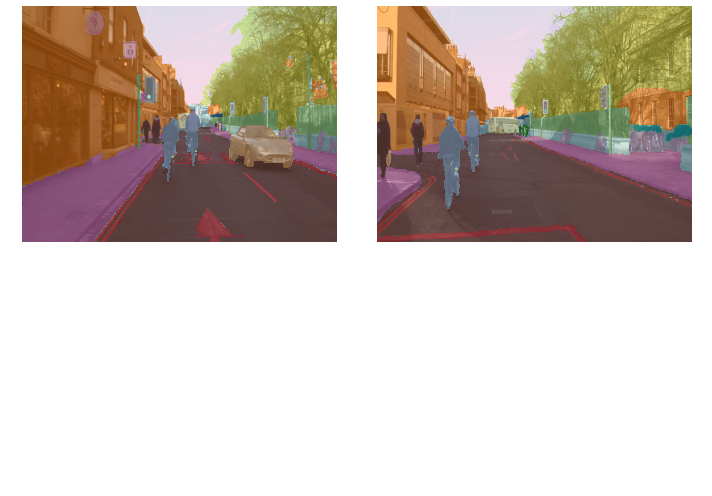

In [24]:
data.show_batch(2, figsize=(10,7), ds_type=DatasetType.Valid)

# Model

In [0]:
name2id = {v:k for k,v in enumerate(codes)}
void_code = name2id['Void']
# When reporting accuracy one shouldnt report Void
def acc_camvid(input, target):
    target = target.squeeze(1)
    mask = target != void_code
    return (input.argmax(dim=1)[mask]==target[mask]).float().mean()

In [0]:
metrics = acc_camvid

In [0]:
wd=1e-2

In [28]:
np.random.seed(42)
learn = unet_learner(data, models.resnet34, metrics=metrics, wd=wd)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/checkpoints/resnet34-333f7ec4.pth


In [0]:
learn.lr_find()

epoch,train_loss,valid_loss,acc_camvid,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


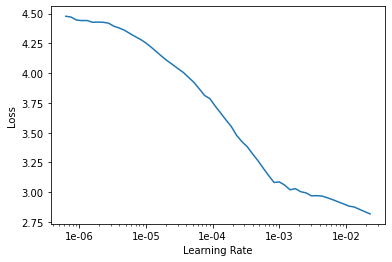

In [0]:
learn.recorder.plot()

In [0]:
lr = 1e-04

In [30]:
learn.fit_one_cycle(10,slice(lr))

epoch,train_loss,valid_loss,acc_camvid,time
0,1.255282,1.067900,0.775676,01:40
1,0.842600,0.717212,0.828648,01:32
2,0.658509,0.616054,0.851430,01:32
3,0.608933,0.529033,0.850902,01:32
4,0.517319,0.416277,0.877789,01:32
5,0.475795,0.415896,0.879810,01:32
6,0.422489,0.320086,0.909738,01:31
7,0.394413,0.313942,0.910404,01:32
8,0.373737,0.299296,0.913811,01:32
9,0.355190,0.301515,0.913147,01:32


In [0]:
learn.save('stage-1')

In [0]:
learn.load('stage-1');

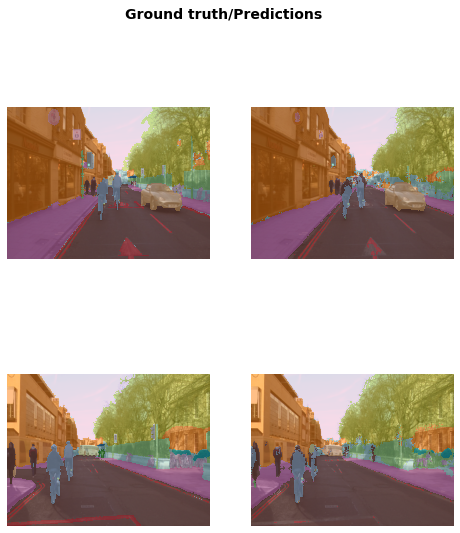

In [33]:
learn.show_results(rows=3,figsize=(8,9))

In [0]:
learn.unfreeze()

In [0]:
learn.lr_find()

epoch,train_loss,valid_loss,acc_camvid,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


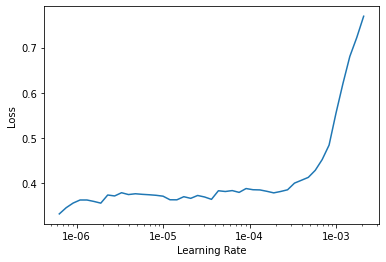

In [0]:
learn.recorder.plot()

In [0]:
lrs = slice(1e-5,lr/5) 
#use of slice
#the last parameter group will use a learning rate of lr, while the other groups will have lr/10.


In [36]:
learn.fit_one_cycle(4,lrs)

epoch,train_loss,valid_loss,acc_camvid,time
0,0.369195,0.288857,0.918916,01:38
1,0.358398,0.289744,0.916330,01:38
2,0.341534,0.281294,0.919110,01:38
3,0.327857,0.283668,0.918638,01:38


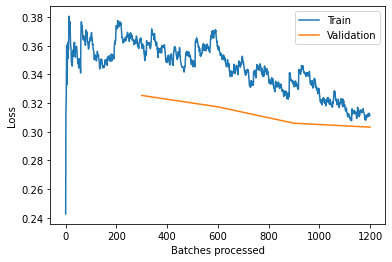

In [0]:
learn.recorder.plot_losses()

In [0]:
# The trick is to increase the learning rate then decrease it
# Refer video 3 1:23 for the reason

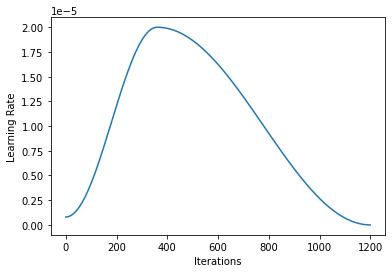

In [0]:
learn.recorder.plot_lr()

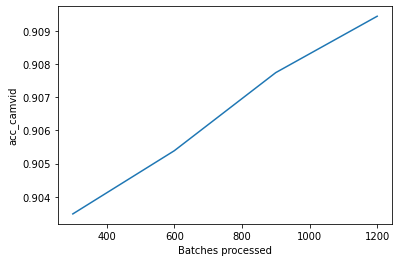

In [0]:
learn.recorder.plot_metrics()

In [0]:
learn.save('stage-2')

# Interpret
The following code is there in [Segmentation Interpretation](https://docs.fast.ai/vision.interpret.html#SegmentationInterpretation.show_xyz) docs from fastai

In [0]:
from fastai.vision import interpret

In [50]:
interp = interpret.SegmentationInterpretation.from_learner(learn)

In [0]:
top_losses, top_idxs = interp.top_losses(sizes=size)

In [55]:
top_losses,top_idxs

(tensor([0.4193, 0.4099, 0.3834, 0.3785, 0.3785, 0.3753, 0.3675, 0.3667, 0.3640,
         0.3631, 0.3612, 0.3591, 0.3589, 0.3571, 0.3523, 0.3519, 0.3517, 0.3478,
         0.3425, 0.3397, 0.3393, 0.3390, 0.3360, 0.3248, 0.3191, 0.3186, 0.3175,
         0.3156, 0.3148, 0.3128, 0.3123, 0.3109, 0.3103, 0.3095, 0.3064, 0.3048,
         0.3034, 0.3024, 0.3023, 0.3023, 0.3011, 0.2986, 0.2981, 0.2975, 0.2964,
         0.2884, 0.2877, 0.2873, 0.2845, 0.2830, 0.2816, 0.2757, 0.2741, 0.2735,
         0.2723, 0.2718, 0.2698, 0.2690, 0.2685, 0.2680, 0.2633, 0.2628, 0.2623,
         0.2618, 0.2587, 0.2585, 0.2584, 0.2484, 0.2481, 0.2469, 0.2467, 0.2463,
         0.2429, 0.2414, 0.2410, 0.2403, 0.2373, 0.2370, 0.2365, 0.2364, 0.2360,
         0.2344, 0.2343, 0.2338, 0.2317, 0.2284, 0.2217, 0.2191, 0.2183, 0.2168,
         0.2161, 0.2142, 0.2023, 0.2000, 0.1971, 0.1886, 0.1873, 0.1850, 0.1848,
         0.1803, 0.1682]),
 tensor([ 80,  41,  57,  89,   1,   0,   2,  38,  50,  13,  55,   8,  58,  16,
   

In [56]:
learn.data.classes

array(['Animal', 'Archway', 'Bicyclist', 'Bridge', 'Building', 'Car', 'CartLuggagePram', 'Child', 'Column_Pole',
       'Fence', 'LaneMkgsDriv', 'LaneMkgsNonDriv', 'Misc_Text', 'MotorcycleScooter', 'OtherMoving', 'ParkingBlock',
       'Pedestrian', 'Road', 'RoadShoulder', 'Sidewalk', 'SignSymbol', 'Sky', 'SUVPickupTruck', 'TrafficCone',
       'TrafficLight', 'Train', 'Tree', 'Truck_Bus', 'Tunnel', 'VegetationMisc', 'Void', 'Wall'], dtype='<U17')

We can generate a confusion matrix similar to what we usually have for classification. Two confusion matrices are generated: ***mean_cm*** which represents the global label performance and ***single_img_cm*** which represents the same thing but for each individual image in dataset.

In [0]:
mean_cm, single_img_cm = interp._generate_confusion()

label,score
Sky,0.976113
Road,0.972544
Tree,0.971491
Sidewalk,0.95477
Building,0.937729
Bicyclist,0.776879
Car,0.762091
Fence,0.731254
Pedestrian,0.660778
Wall,0.585136


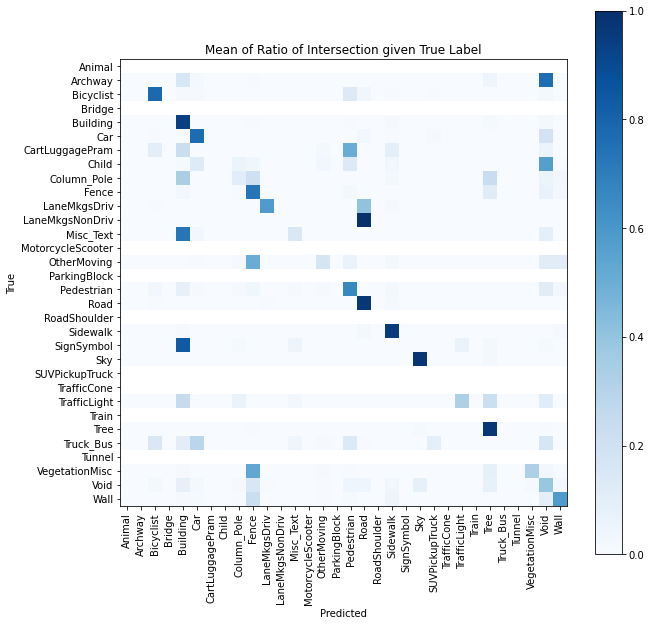

In [58]:
df = interp._plot_intersect_cm(mean_cm,"Mean of Ratio of Intersection given True Label")

Next let's look at the single worst prediction in our dataset.

label,score
Tree,0.976962
Sky,0.973093
Road,0.955319
Pedestrian,0.945669
Sidewalk,0.929916
Fence,0.888359
Building,0.794828
Bicyclist,0.723653
Wall,0.695337
TrafficLight,0.570091


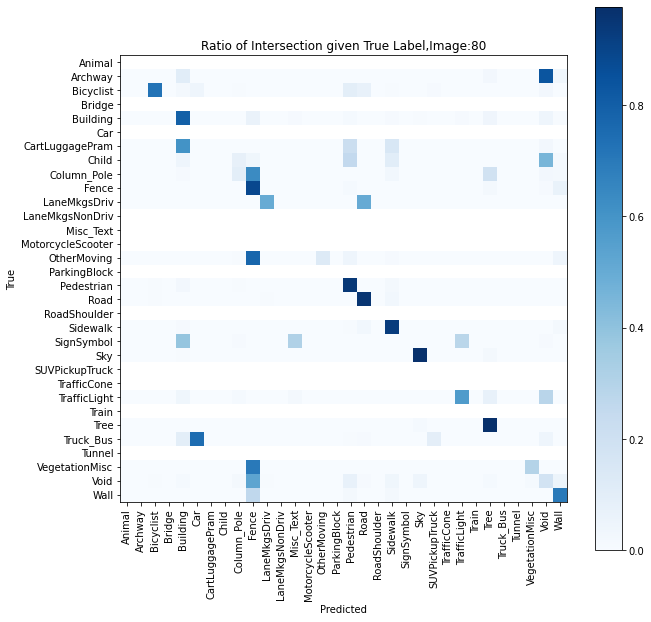

In [59]:
i = top_idxs[0]
df = interp._plot_intersect_cm(single_img_cm[i],f"Ratio of Intersection given True Label,Image:{i}")

Finally we visually inspect this single prediction

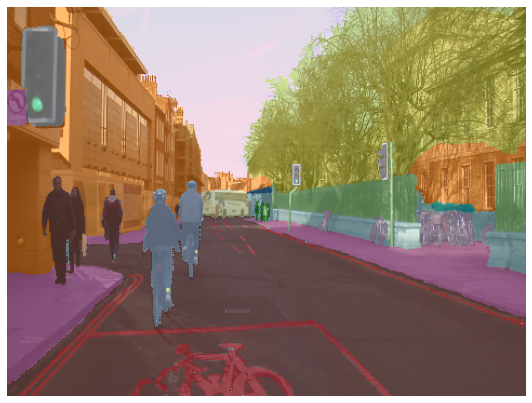

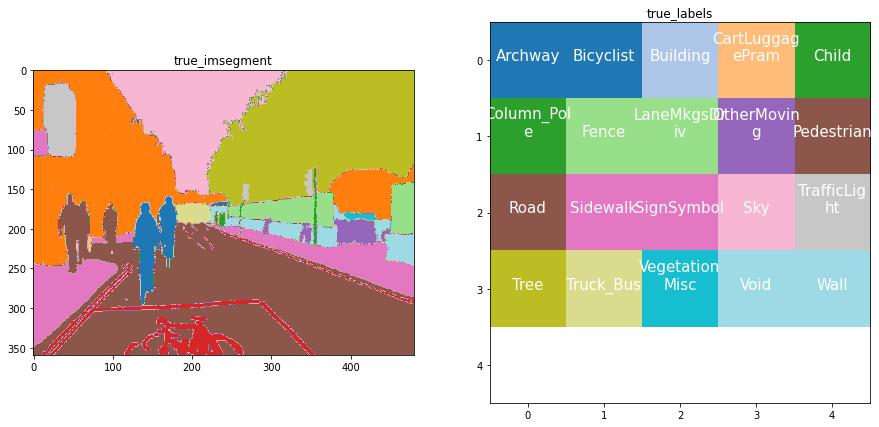

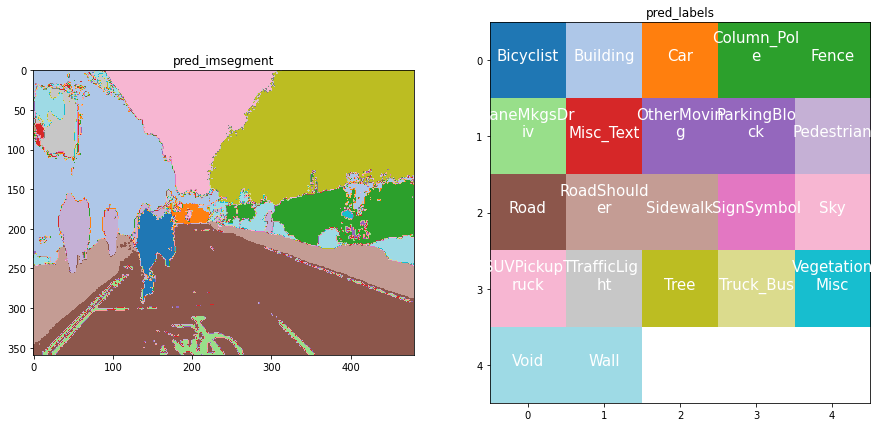

In [60]:
interp.show_xyz(i,sz=15)

# Go Big


In [0]:
# You may have to restart kernel and come back to this stage if you run out of memory and also need to decrease bs.
size = src_size
bs = 1

In [0]:
data = (SegmentationItemList.from_folder(path_img)
        #Where to find the data? -> in path_img and its subfolders
        .split_by_fname_file('../valid.txt')
        #How to split in train/valid? -> randomly with the default 20% in valid
        .label_from_func(get_y_fn, classes=codes)
        #How to label? -> use the label function on the file name of the data
        .transform(get_transforms(), tfm_y=True, size=size)
        #Data augmentation? -> use tfms with a size of 128, also transform the label images
        .databunch(bs=bs))

In [0]:
learn.data = data

In [0]:
data.train_ds[0][0].shape

torch.Size([3, 720, 960])

In [0]:
learn.freeze()

In [0]:
learn.load('stage-1');

In [0]:
learn.lr_find()

epoch,train_loss,valid_loss,acc_camvid,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


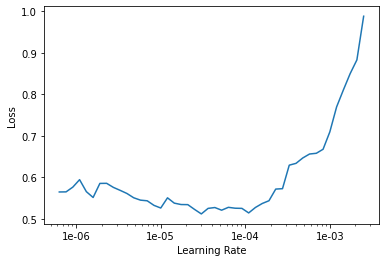

In [0]:
learn.recorder.plot()

In [0]:
lr = 1e-4

In [0]:
learn.fit_one_cycle(10,slice(lr)) #to_fp16()

epoch,train_loss,valid_loss,acc_camvid,time
0,0.245584,0.293128,0.915612,06:53


KeyboardInterrupt: ignored

In [0]:
#Takes a lot of time so end